In [110]:
import pandas as pd
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, OneClassSVM
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')

#### Load Dataset

In [113]:
file_path = "csic_database.csv"
df = pd.read_csv(file_path)

#### Size of Dataset

In [116]:
df.shape

(61065, 17)

#### Combine text features

In [119]:
df["text"] = (
    df["Method"].fillna("") + " " +
    df["URL"].fillna("") + " " +
    df["content"].fillna("") + " " +
    df["User-Agent"].fillna("")
)

#### Class Distribution (Attack vs Normal)

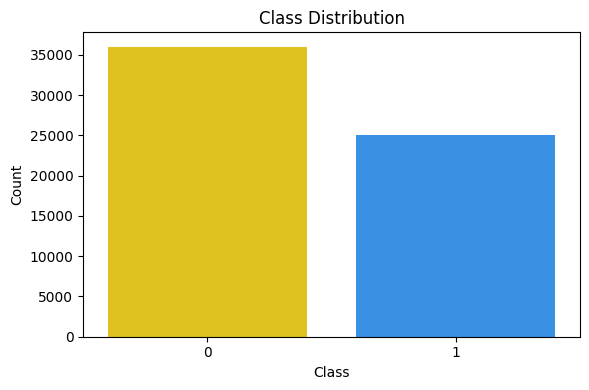

In [122]:
plt.figure(figsize=(6, 4))
custom_colors = ["#FFD700", "#1E90FF"] 
sns.countplot(x='classification', hue='classification', data=df, palette=custom_colors, legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### Binary Classification (Attack vs Normal)

In [125]:
X = df["text"]
y = df["classification"]

#### Split Data

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### TF-IDF vectorization

In [131]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#### Define and Train Models

In [138]:
binary_models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=2000, C=1.0, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        eval_metric="logloss", use_label_encoder=False
    ),
    "SVM": SVC(kernel="linear", probability=True)
}

results = {}

for name, model in binary_models.items():
    print(f"\nTraining {name}")
    model.fit(X_train_vec, y_train)  
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")  
    
    results[name] = {"accuracy": acc, "f1": f1, "y_pred": y_pred}
    print(f"{name}: Accuracy = {acc:.4f}, Weighted F1 = {f1:.4f}")



Training Random Forest
Random Forest: Accuracy = 0.9046, Weighted F1 = 0.9037

Training Logistic Regression
Logistic Regression: Accuracy = 0.9727, Weighted F1 = 0.9726

Training XGBoost
XGBoost: Accuracy = 0.9718, Weighted F1 = 0.9717

Training SVM
SVM: Accuracy = 0.9833, Weighted F1 = 0.9833


#### Classification Reports and Confusion Matrices


Random Forest Classification Report
              precision    recall  f1-score   support

      Normal       0.89      0.96      0.92      7148
      Attack       0.93      0.83      0.88      5065

    accuracy                           0.90     12213
   macro avg       0.91      0.89      0.90     12213
weighted avg       0.91      0.90      0.90     12213



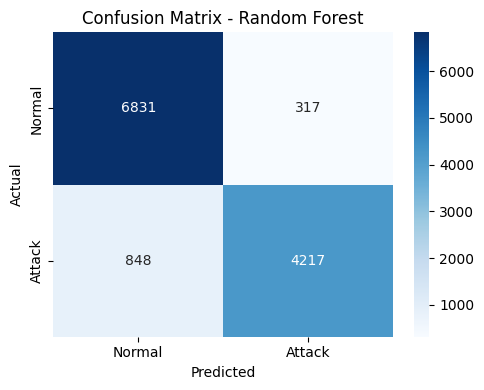


Logistic Regression Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.98      7148
      Attack       0.99      0.95      0.97      5065

    accuracy                           0.97     12213
   macro avg       0.98      0.97      0.97     12213
weighted avg       0.97      0.97      0.97     12213



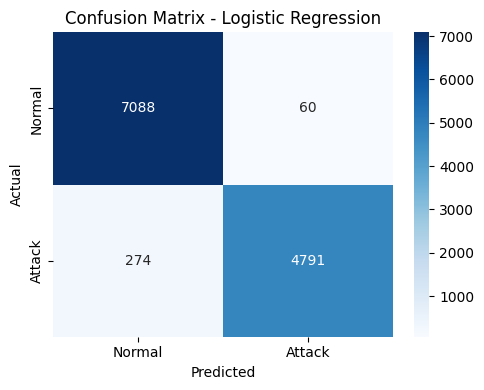


XGBoost Classification Report
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98      7148
      Attack       1.00      0.94      0.96      5065

    accuracy                           0.97     12213
   macro avg       0.98      0.97      0.97     12213
weighted avg       0.97      0.97      0.97     12213



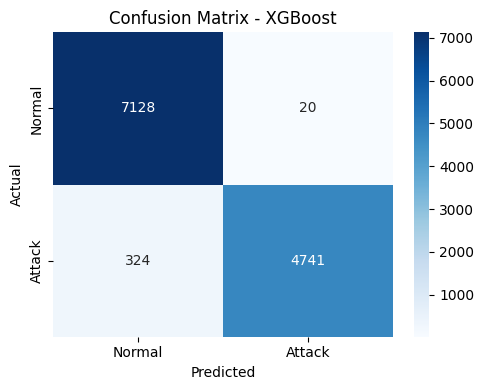


SVM Classification Report
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7148
      Attack       0.99      0.96      0.98      5065

    accuracy                           0.98     12213
   macro avg       0.99      0.98      0.98     12213
weighted avg       0.98      0.98      0.98     12213



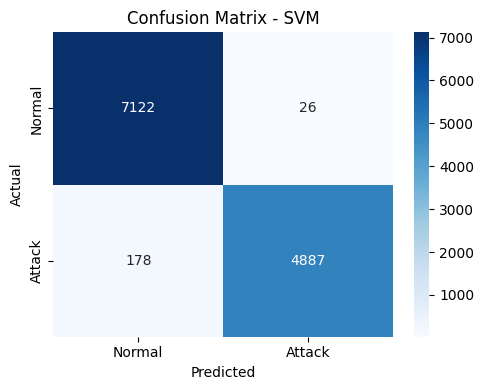

In [140]:
labels = ["Normal", "Attack"]
for name, res in results.items():
    print(f"\n{name} Classification Report")
    print(classification_report(y_test, res["y_pred"], target_names=labels, zero_division=0))
    
    cm = confusion_matrix(y_test, res["y_pred"])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

#### Final Performance Summary

In [142]:
perf = []
for name, res in results.items():
    perf.append({"Model": name, "Accuracy": res["accuracy"], "Weighted F1": res["f1"]})
perf_df = pd.DataFrame(perf).sort_values("Weighted F1", ascending=False)

print("\nPerformance Summary:")
display(perf_df)
print(f"Best Model: {perf_df.iloc[0]['Model']} with Weighted F1 = {perf_df.iloc[0]['Weighted F1']:.4f}")


Performance Summary:


,Model,Accuracy,Weighted F1
3,SVM,0.983296,0.983257
1,Logistic Regression,0.972652,0.972559
2,XGBoost,0.971833,0.971691
0,Random Forest,0.904610,0.903680


Best Model: SVM with Weighted F1 = 0.9833


#### Unsupervised Anomaly Detection: One-Class SVM

One-Class SVM (normal-only training) with hyperparameter tuning
nu=0.01, Accuracy: 80.98%
nu=0.05, Accuracy: 90.52%
nu=0.1, Accuracy: 91.35%
nu=0.2, Accuracy: 88.17%

Best nu for One-Class SVM: 0.1 with accuracy 91.35%

Final One-Class SVM Accuracy: 91.35%
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      7148
           1       0.92      0.86      0.89      5065

    accuracy                           0.91     12213
   macro avg       0.92      0.91      0.91     12213
weighted avg       0.91      0.91      0.91     12213



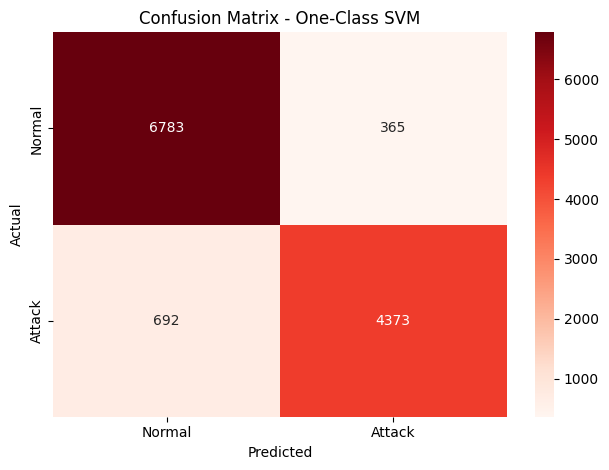

In [108]:
# Filter only normal samples from training set
normal_indices = np.where(y_train == 0)[0]  # 0 = Normal label
X_norm = X_train_vec[normal_indices]

print("One-Class SVM (normal-only training) with hyperparameter tuning")

best_acc = 0
best_nu = None


for nu in [0.01, 0.05, 0.1, 0.2]:
    ocsvm = OneClassSVM(gamma='auto', nu=nu)
    ocsvm.fit(X_norm)

    # Predict on test set
    preds_ocsvm = ocsvm.predict(X_test_vec)

    # Convert -1 (anomaly) to 1, and 1 (inlier) to 0
    anoms_svm = np.where(preds_ocsvm == -1, 1, 0)

    acc = accuracy_score(y_test, anoms_svm)
    print(f"nu={nu}, Accuracy: {acc * 100:.2f}%")

    if acc > best_acc:
        best_acc = acc
        best_nu = nu

print(f"\nBest nu for One-Class SVM: {best_nu} with accuracy {best_acc * 100:.2f}%")

# Final model with best nu
ocsvm = OneClassSVM(gamma='auto', nu=best_nu)
ocsvm.fit(X_norm)
preds_ocsvm = ocsvm.predict(X_test_vec)
anoms_svm = np.where(preds_ocsvm == -1, 1, 0)

# Evaluation
print(f"\nFinal One-Class SVM Accuracy: {accuracy_score(y_test, anoms_svm) * 100:.2f}%")
print(classification_report(y_test, anoms_svm))

cm = confusion_matrix(y_test, anoms_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix - One-Class SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#### Unsupervised Anomaly Detection: LocalOutlierFactor + PCA

LOF + PCA (SVD) for Anomaly Detection
Grid searching LOF parameters with PCA
n_neighbors=5, contamination=0.01, Accuracy: 89.90%
n_neighbors=5, contamination=0.03, Accuracy: 90.47%
n_neighbors=5, contamination=0.05, Accuracy: 86.91%
n_neighbors=5, contamination=0.08, Accuracy: 83.74%
n_neighbors=5, contamination=0.1, Accuracy: 76.31%
n_neighbors=10, contamination=0.01, Accuracy: 89.34%
n_neighbors=10, contamination=0.03, Accuracy: 90.08%
n_neighbors=10, contamination=0.05, Accuracy: 86.42%
n_neighbors=10, contamination=0.08, Accuracy: 83.70%
n_neighbors=10, contamination=0.1, Accuracy: 76.36%

Best LOF Config (with PCA): n_neighbors=5, contamination=0.03, Accuracy: 90.47%

Final LOF Accuracy: 90.47%
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7148
           1       0.86      0.91      0.89      5065

    accuracy                           0.90     12213
   macro avg       0.90      0.91      0.90     12213
weighted avg       

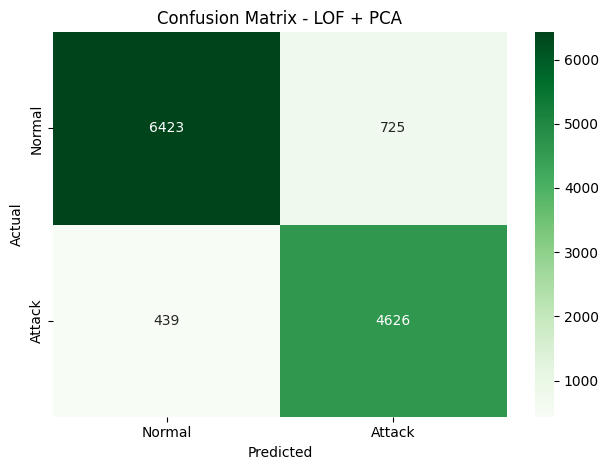

In [65]:
print("LOF + PCA (SVD) for Anomaly Detection")

# SVD for dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train_vec)
X_test_svd = svd.transform(X_test_vec)

# Select normal samples
normal_indices = np.where(y_train == 0)[0]
X_norm_svd = X_train_svd[normal_indices]

best_acc_lof = 0
best_n = None
best_c = None

print("Grid searching LOF parameters with PCA")

for n in range(5, 15, 5):
    for c in [0.01, 0.03, 0.05, 0.08, 0.1]:
        lof = LocalOutlierFactor(n_neighbors=n, contamination=c, novelty=True)
        lof.fit(X_norm_svd)
        preds_lof = lof.predict(X_test_svd)
        anoms_lof = np.where(preds_lof == -1, 1, 0)
        acc_lof = accuracy_score(y_test, anoms_lof)
        print(f"n_neighbors={n}, contamination={c}, Accuracy: {acc_lof * 100:.2f}%")

        if acc_lof > best_acc_lof:
            best_acc_lof = acc_lof
            best_n = n
            best_c = c

print(f"\nBest LOF Config (with PCA): n_neighbors={best_n}, contamination={best_c}, Accuracy: {best_acc_lof * 100:.2f}%")

# Final model
lof = LocalOutlierFactor(n_neighbors=best_n, contamination=best_c, novelty=True)
lof.fit(X_norm_svd)
preds_lof = lof.predict(X_test_svd)
anoms_lof = np.where(preds_lof == -1, 1, 0)

print(f"\nFinal LOF Accuracy: {accuracy_score(y_test, anoms_lof) * 100:.2f}%")
print(classification_report(y_test, anoms_lof))
cm = confusion_matrix(y_test, anoms_lof)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix - LOF + PCA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()